In [1]:
# Basic libraries
import pandas as pd
from itertools import combinations
import logging

# Project libraries
# set path to local modules and submodules
import sys, os
sys.path.append(os.path.abspath("src")) # add src folder to path
# import local modules and submodules
import data_ravers_utils.file_handler as fl
import data_ravers_utils.eda_utils as eda
import data_ravers_utils.model_rf_classifier as rfc
import data_ravers_utils.visualization as plots

# Machine learning
from sklearn.model_selection import train_test_split

# Settings
pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings



# Target / Features split

Modelling strategy:
- Column `is_donation` with values 0 or 1.
  - What to consider as donation case true / false from `overpayment` and `amount over`?
    - Rule: `amount_over_usd` > 0 OR `overpayment` > 0.
  - Do not include features that directly set the donation flag in the train subdset:
    - `amount_over_usd`, `overpayment`, `amount_paid`.
  - Keep `item_price`, `discount`. Corellated, but not directly.

In [2]:
df_filename = 'bandcamp-sales-v2-encoded'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,amount_paid_usd,amount_over_usd,item_price_usd,overpayment_usd,discount_usd,is_donation,artist_encoded,media_type_details_encoded,discography_size,merch_type_encoded,is_bundle,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,is_weekend,is_weekday,cc_ae,cc_af,cc_ag,cc_ai,cc_al,cc_am,cc_an,cc_ar,cc_at,cc_au,cc_aw,cc_ax,cc_az,cc_ba,cc_bb,cc_bd,cc_be,cc_bg,cc_bh,cc_bi,cc_bm,cc_bn,cc_bo,cc_br,cc_bs,cc_bw,cc_by,cc_bz,cc_c2,cc_ca,cc_cf,cc_ch,cc_ci,cc_ck,cc_cl,cc_cm,cc_cn,cc_co,cc_cr,cc_cw,cc_cy,cc_cz,cc_de,cc_dk,cc_dm,cc_do,cc_dz,cc_ec,cc_ee,cc_eg,cc_es,cc_et,cc_fi,cc_fj,cc_fo,cc_fr,cc_ga,cc_gb,cc_gd,cc_ge,cc_gf,cc_gg,cc_gh,cc_gi,cc_gl,cc_gp,cc_gr,cc_gt,cc_gu,cc_gy,cc_hk,cc_hm,cc_hn,cc_hr,cc_hu,cc_hy,cc_id,cc_ie,cc_il,cc_im,cc_in,cc_is,cc_it,cc_je,cc_jm,cc_jo,cc_jp,cc_ke,cc_kg,cc_kh,cc_kn,cc_kr,cc_kw,cc_ky,cc_kz,cc_la,cc_lb,cc_lc,cc_li,cc_lk,cc_lr,cc_ls,cc_lt,cc_lu,cc_lv,cc_ly,cc_ma,cc_mc,cc_md,cc_me,cc_mk,cc_ml,cc_mm,cc_mn,cc_mo,cc_mq,cc_mt,cc_mu,cc_mv,cc_mw,cc_mx,cc_my,cc_mz,cc_na,cc_nc,cc_nf,cc_ng,cc_ni,cc_nl,cc_no,cc_np,cc_nz,cc_om,cc_pa,cc_pe,cc_pf,cc_pg,cc_ph,cc_pk,cc_pl,cc_pr,cc_ps,cc_pt,cc_pw,cc_py,cc_qa,cc_re,cc_ro,cc_rs,cc_ru,cc_rw,cc_sa,cc_sc,cc_se,cc_sg,cc_si,cc_sk,cc_sn,cc_so,cc_sv,cc_sz,cc_tc,cc_tg,cc_th,cc_tn,cc_tr,cc_tt,cc_tw,cc_tz,cc_ua,cc_ug,cc_us,cc_uy,cc_uz,cc_vc,cc_ve,cc_vi,cc_vn,cc_vu,cc_wf,cc_xk,cc_yt,cc_za,cc_zm,cc_zw,mt_Physical media,mt_Tape,mt_Vinyl,mt_bundle,mt_digital
0,9.99,0.0,9.99,2.288818e-07,0.000000e+00,1,9.707326,2,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.30,0.0,1.30,0.000000e+00,0.000000e+00,0,8.293014,2,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3.90,0.0,3.90,0.000000e+00,4.440892e-16,0,8.931315,2,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,12.39,0.0,12.39,0.000000e+00,1.776357e-15,0,9.247368,3,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.00,0.0,1.00,0.000000e+00,0.000000e+00,0,3.863418,4,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [3]:
features_datetime = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']
features_geo_encoded = ['cc_ae', 'cc_af', 'cc_ag', 'cc_ai', 'cc_al', 'cc_am', 'cc_an', 'cc_ar', 'cc_at', 'cc_au', 'cc_aw', 'cc_ax', 'cc_az', 'cc_ba', 'cc_bb', 'cc_bd', 'cc_be', 'cc_bg', 'cc_bh', 'cc_bi', 'cc_bm', 'cc_bn', 'cc_bo', 'cc_br', 'cc_bs', 'cc_bw', 'cc_by', 'cc_bz', 'cc_c2', 'cc_ca', 'cc_cf', 'cc_ch', 'cc_ci', 'cc_ck', 'cc_cl', 'cc_cm', 'cc_cn', 'cc_co', 'cc_cr', 'cc_cw', 'cc_cy', 'cc_cz', 'cc_de', 'cc_dk', 'cc_dm', 'cc_do', 'cc_dz', 'cc_ec', 'cc_ee', 'cc_eg', 'cc_es', 'cc_et', 'cc_fi', 'cc_fj', 'cc_fo', 'cc_fr', 'cc_ga', 'cc_gb', 'cc_gd', 'cc_ge', 'cc_gf', 'cc_gg', 'cc_gh', 'cc_gi', 'cc_gl', 'cc_gp', 'cc_gr', 'cc_gt', 'cc_gu', 'cc_gy', 'cc_hk', 'cc_hm', 'cc_hn', 'cc_hr', 'cc_hu', 'cc_hy', 'cc_id', 'cc_ie', 'cc_il', 'cc_im', 'cc_in', 'cc_is', 'cc_it', 'cc_je', 'cc_jm', 'cc_jo', 'cc_jp', 'cc_ke', 'cc_kg', 'cc_kh', 'cc_kn', 'cc_kr', 'cc_kw', 'cc_ky', 'cc_kz', 'cc_la', 'cc_lb', 'cc_lc', 'cc_li', 'cc_lk', 'cc_lr', 'cc_ls', 'cc_lt', 'cc_lu', 'cc_lv', 'cc_ly', 'cc_ma', 'cc_mc', 'cc_md', 'cc_me', 'cc_mk', 'cc_ml', 'cc_mm', 'cc_mn', 'cc_mo', 'cc_mq', 'cc_mt', 'cc_mu', 'cc_mv', 'cc_mw', 'cc_mx', 'cc_my', 'cc_mz', 'cc_na', 'cc_nc', 'cc_nf', 'cc_ng', 'cc_ni', 'cc_nl', 'cc_no', 'cc_np', 'cc_nz', 'cc_om', 'cc_pa', 'cc_pe', 'cc_pf', 'cc_pg', 'cc_ph', 'cc_pk', 'cc_pl', 'cc_pr', 'cc_ps', 'cc_pt', 'cc_pw', 'cc_py', 'cc_qa', 'cc_re', 'cc_ro', 'cc_rs', 'cc_ru', 'cc_rw', 'cc_sa', 'cc_sc', 'cc_se', 'cc_sg', 'cc_si', 'cc_sk', 'cc_sn', 'cc_so', 'cc_sv', 'cc_sz', 'cc_tc', 'cc_tg', 'cc_th', 'cc_tn', 'cc_tr', 'cc_tt', 'cc_tw', 'cc_tz', 'cc_ua', 'cc_ug', 'cc_us', 'cc_uy', 'cc_uz', 'cc_vc', 'cc_ve', 'cc_vi', 'cc_vn', 'cc_vu', 'cc_wf', 'cc_xk', 'cc_yt', 'cc_za', 'cc_zm', 'cc_zw']
features_payment = ['amount_paid_usd', 'amount_over_usd', 'item_price_usd', 'overpayment_usd', 'discount_usd', 'is_donation']
features_product_encoded = ['artist_encoded', 'discography_size', 'is_bundle', 'media_type_details_encoded', 'merch_type_encoded', 'mt_Physical media', 'mt_Tape', 'mt_Vinyl', 'mt_bundle', 'mt_digital']

In [4]:
target_variable = 'is_donation'
features_payment.remove(target_variable)

In [5]:
features_to_drop = ['amount_over_usd', 'overpayment_usd', 'amount_paid_usd']
features_payment = [col for col in features_datetime if col not in features_to_drop]
features_all = features_datetime + features_geo_encoded + features_payment + features_product_encoded


In [6]:
df.drop(columns=features_to_drop, inplace=True)

In [7]:
df[target_variable].describe()

count    1000000.000000
mean           0.346527
std            0.475864
min            0.000000
25%            0.000000
50%            0.000000
75%            1.000000
max            1.000000
Name: is_donation, dtype: float64

## Backup checkpoint

In [8]:
# save backup
df_filename = 'bandcamp-sales-v4-rfc'
fl.save_df_pickle(df, df_filename)

In [9]:
# restore backup
df_filename = 'bandcamp-sales-v4-rfc'
data = fl.read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,item_price_usd,discount_usd,is_donation,artist_encoded,media_type_details_encoded,discography_size,merch_type_encoded,is_bundle,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,is_weekend,is_weekday,cc_ae,cc_af,cc_ag,cc_ai,cc_al,cc_am,cc_an,cc_ar,cc_at,cc_au,cc_aw,cc_ax,cc_az,cc_ba,cc_bb,cc_bd,cc_be,cc_bg,cc_bh,cc_bi,cc_bm,cc_bn,cc_bo,cc_br,cc_bs,cc_bw,cc_by,cc_bz,cc_c2,cc_ca,cc_cf,cc_ch,cc_ci,cc_ck,cc_cl,cc_cm,cc_cn,cc_co,cc_cr,cc_cw,cc_cy,cc_cz,cc_de,cc_dk,cc_dm,cc_do,cc_dz,cc_ec,cc_ee,cc_eg,cc_es,cc_et,cc_fi,cc_fj,cc_fo,cc_fr,cc_ga,cc_gb,cc_gd,cc_ge,cc_gf,cc_gg,cc_gh,cc_gi,cc_gl,cc_gp,cc_gr,cc_gt,cc_gu,cc_gy,cc_hk,cc_hm,cc_hn,cc_hr,cc_hu,cc_hy,cc_id,cc_ie,cc_il,cc_im,cc_in,cc_is,cc_it,cc_je,cc_jm,cc_jo,cc_jp,cc_ke,cc_kg,cc_kh,cc_kn,cc_kr,cc_kw,cc_ky,cc_kz,cc_la,cc_lb,cc_lc,cc_li,cc_lk,cc_lr,cc_ls,cc_lt,cc_lu,cc_lv,cc_ly,cc_ma,cc_mc,cc_md,cc_me,cc_mk,cc_ml,cc_mm,cc_mn,cc_mo,cc_mq,cc_mt,cc_mu,cc_mv,cc_mw,cc_mx,cc_my,cc_mz,cc_na,cc_nc,cc_nf,cc_ng,cc_ni,cc_nl,cc_no,cc_np,cc_nz,cc_om,cc_pa,cc_pe,cc_pf,cc_pg,cc_ph,cc_pk,cc_pl,cc_pr,cc_ps,cc_pt,cc_pw,cc_py,cc_qa,cc_re,cc_ro,cc_rs,cc_ru,cc_rw,cc_sa,cc_sc,cc_se,cc_sg,cc_si,cc_sk,cc_sn,cc_so,cc_sv,cc_sz,cc_tc,cc_tg,cc_th,cc_tn,cc_tr,cc_tt,cc_tw,cc_tz,cc_ua,cc_ug,cc_us,cc_uy,cc_uz,cc_vc,cc_ve,cc_vi,cc_vn,cc_vu,cc_wf,cc_xk,cc_yt,cc_za,cc_zm,cc_zw,mt_Physical media,mt_Tape,mt_Vinyl,mt_bundle,mt_digital
0,9.99,0.000000e+00,1,9.707326,2,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.30,0.000000e+00,0,8.293014,2,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3.90,4.440892e-16,0,8.931315,2,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,12.39,1.776357e-15,0,9.247368,3,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.00,0.000000e+00,0,3.863418,4,0,2,0,-0.5,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Create a base model

In [12]:
logging.getLogger().setLevel(logging.INFO)

base_model, dict_test_results = rfc.random_forest_classifier_control(df, features_all, target_variable, test_size=0.3, random_state=15, n_estimators=10)

for key, value in dict_test_results.items():
    print(f"{key}:\n {value}")

accuracy:
 0.6648
class_report:
               precision    recall  f1-score   support

           0       0.67      0.96      0.79    196334
           1       0.58      0.10      0.18    103666

    accuracy                           0.66    300000
   macro avg       0.63      0.53      0.48    300000
weighted avg       0.64      0.66      0.58    300000

conf_matrix:
 [[188603   7731]
 [ 92829  10837]]


<Figure size 800x600 with 0 Axes>

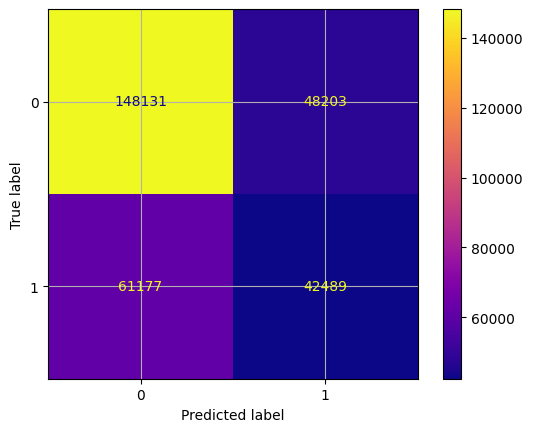

In [27]:
plots.confusion_matrix(dict_test_results['conf_matrix'])

## Save base model

In [28]:
# Save model to a file
fl.save_model_pickle(model=base_model, filename='rf_classifier_base_model')

INFO:root:Model file pickle is updated: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/models/rf_classifier_base_model.pkl
INFO:root:Added to .gitignore: models/rf_classifier_base_model.pkl


# Grid search

In [11]:
test_size=0.3
random_state=15

# Test/Train split
X = df[features_all]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

This cell will run ~ 2 mins:

In [9]:
best_params, best_score = rfc.grid_search(base_model, X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [10]:
print(best_params)

{'max_depth': 20, 'min_samples_split': 10}


In [11]:
print(best_score)

0.66342


# Feature importance

In [12]:
importances, indices = rfc.feature_importances(base_model, X_train)

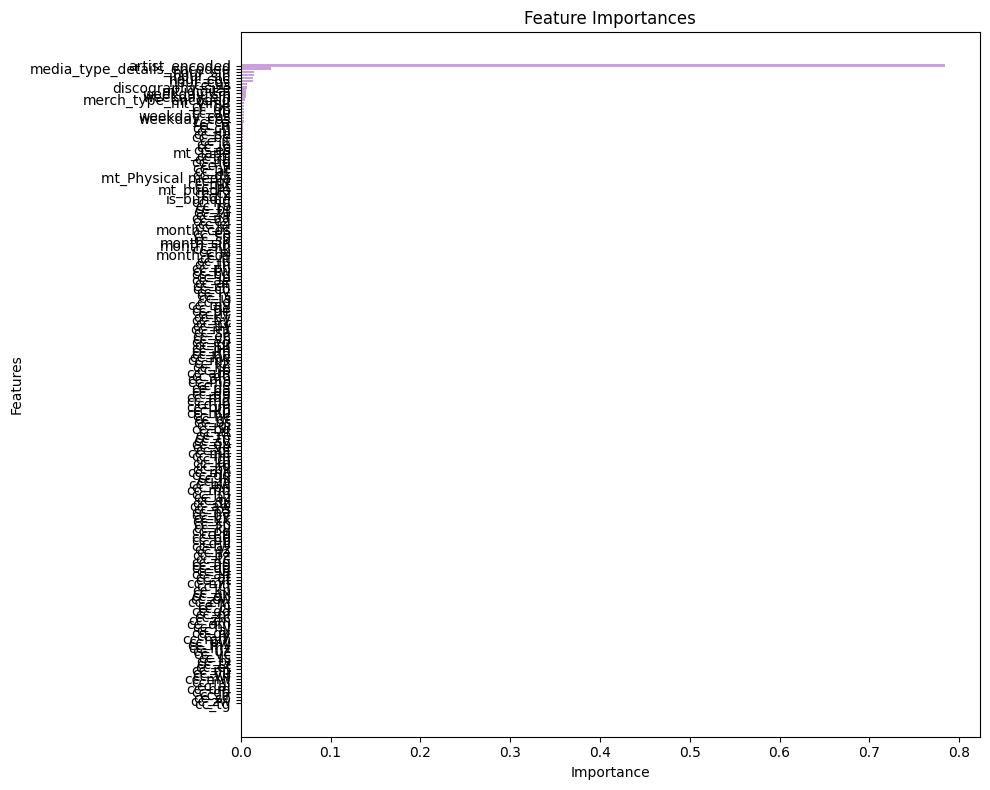

In [13]:
plots.plot_bar_feature_importance(importances, indices, features_all)

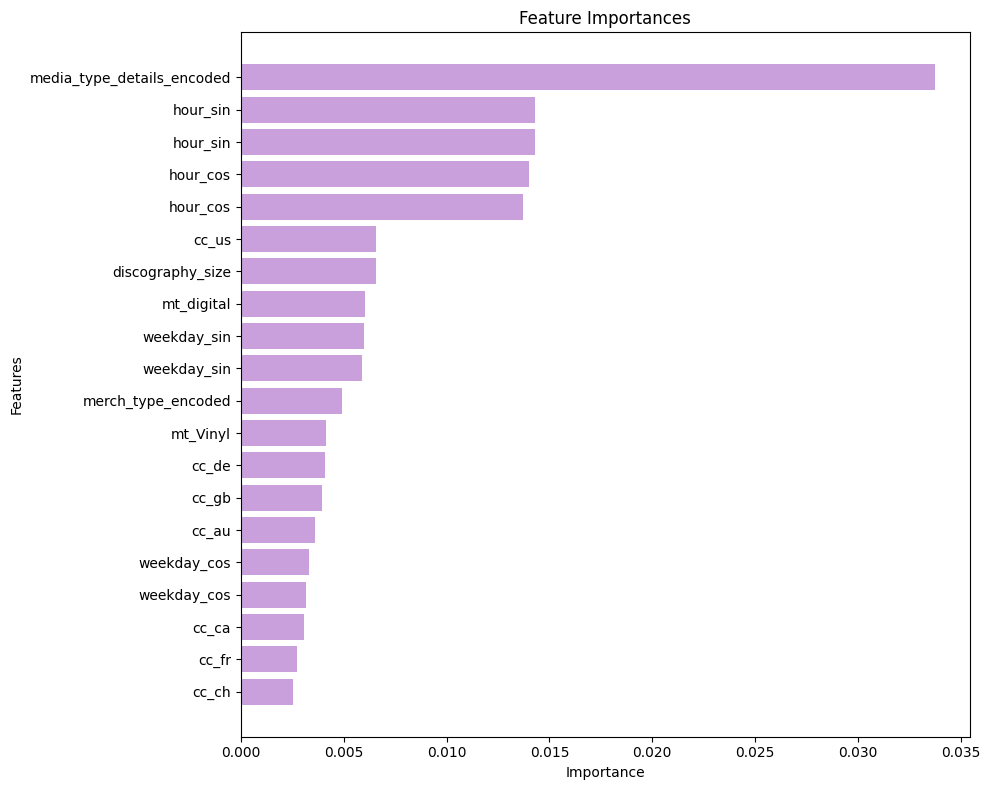

In [14]:
plots.plot_bar_feature_importance(importances, indices[1:21], features_all)

In [14]:
top_features = [
    "media_type_details_encoded",
    "hour_sin",
    "hour_sin",
    "hour_cos",
    "hour_cos",
    "cc_us",
    "discography_size",
    "mt_digital",
    "weekday_sin",
    "weekday_sin",
    "merch_type_encoded",
    "mt_Vinyl",
    "cc_de",
    "cc_gb",
    "cc_au",
    "weekday_cos",
    "weekday_cos",
    "cc_ca",
    "cc_fr",
    "cc_ch"
]

# Second model

In [15]:
second_model, dict_test_results = rfc.random_forest_classifier_control(df, top_features, target_variable, test_size=0.3, random_state=15, n_estimators=10)

for key, value in dict_test_results.items():
    print(f"{key}:\n {value}")

accuracy:
 0.6557666666666667
class_report:
               precision    recall  f1-score   support

           0       0.67      0.95      0.78    196334
           1       0.51      0.09      0.16    103666

    accuracy                           0.66    300000
   macro avg       0.59      0.52      0.47    300000
weighted avg       0.61      0.66      0.57    300000

conf_matrix:
 [[187219   9115]
 [ 94155   9511]]


<Figure size 800x600 with 0 Axes>

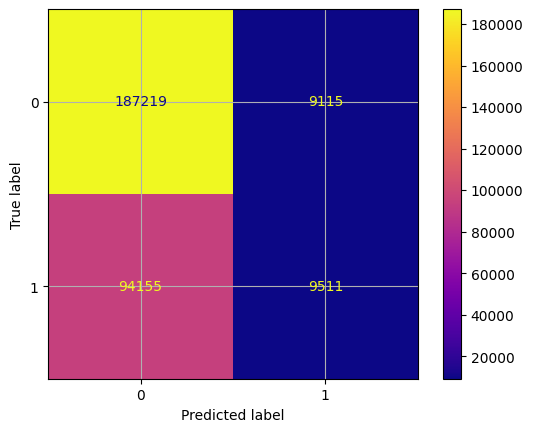

In [16]:
plots.confusion_matrix(dict_test_results['conf_matrix'])

## Save best model

In [19]:
# Save model to a file
fl.save_model_pickle(model=second_model, filename='rf_classifier_best_model')

INFO:root:Model file pickle is updated: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/big_projects/midproject-bandcamp-insights/models/rf_classifier_best_model.pkl
